In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\murtozalikhon\brain-tumor-multimodal-image-ct-and-mri\versions\1


In [2]:
import os
import pandas as pd

In [3]:
ct_path = os.path.join(path, "Dataset/Brain Tumor CT scan Images")
mri_path = os.path.join(path, "Dataset/Brain Tumor MRI images")

In [4]:
# Load CT images
CT_Tumor = [os.path.join(ct_path, "Tumor", f) for f in os.listdir(os.path.join(ct_path, "Tumor")) if f.lower().endswith(('.png','.jpg','.jpeg'))]
CT_Healthy = [os.path.join(ct_path, "Healthy", f) for f in os.listdir(os.path.join(ct_path, "Healthy")) if f.lower().endswith(('.png','.jpg','.jpeg'))]

# Load MRI images
MRI_Tumor = [os.path.join(mri_path, "Tumor", f) for f in os.listdir(os.path.join(mri_path, "Tumor")) if f.lower().endswith(('.png','.jpg','.jpeg'))]
MRI_Healthy = [os.path.join(mri_path, "Healthy", f) for f in os.listdir(os.path.join(mri_path, "Healthy")) if f.lower().endswith(('.png','.jpg','.jpeg'))]

print(f"CT Tumor: {len(CT_Tumor)}, CT Healthy: {len(CT_Healthy)}")
print(f"MRI Tumor: {len(MRI_Tumor)}, MRI Healthy: {len(MRI_Healthy)}")

CT Tumor: 2318, CT Healthy: 2300
MRI Tumor: 3000, MRI Healthy: 2000


In [5]:
files = CT_Tumor + MRI_Tumor + CT_Healthy + MRI_Healthy
labels = [1]*len(CT_Tumor) + [1]*len(MRI_Tumor) + [0]*len(CT_Healthy) + [0]*len(MRI_Healthy)

# Combine into DataFrame
df = pd.DataFrame({'filename': files, 'class': labels})

In [6]:
from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], shuffle=True, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], shuffle=True, random_state=42)

In [7]:
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_test = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [10]:
datagen_test  = ImageDataGenerator(rescale=1./255)
datagen_valid = ImageDataGenerator(rescale=1./255)

In [36]:
# Train generator (augmentation is fine here)
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Validation generator (no augmentation, only rescale)
validation_generator = datagen_valid.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Test generator (no augmentation, only rescale)
test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 6732 validated image filenames belonging to 2 classes.
Found 1443 validated image filenames belonging to 2 classes.
Found 1443 validated image filenames belonging to 2 classes.


In [12]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['class']), y=train_df['class'])
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(1.1182724252491694), 1: np.float64(0.9043524986566363)}


In [ ]:
# CNN Model 

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,874,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,396,801 (73.99 MB)

 Trainable params: 19,395,841 (73.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "best_cnn_model.keras"

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]


In [15]:
history = cnn_model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    class_weight=class_weights,   
    callbacks=callbacks
)

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5712 - loss: 1.3160  
Epoch 1: val_accuracy improved from None to 0.55301, saving model to best_cnn_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 545s 3s/step - accuracy: 0.5957 - loss: 1.0762 - val_accuracy: 0.5530 - val_loss: 1.7950 - learning_rate: 1.0000e-04
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6562 - loss: 0.7460  
Epoch 2: val_accuracy did not improve from 0.55301
211/211 ━━━━━━━━━━━━━━━━━━━━ 485s 2s/step - accuracy: 0.6723 - loss: 0.6883 - val_accuracy: 0.5523 - val_loss: 0.9808 - learning_rate: 1.0000e-04
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7336 - loss: 0.5487  
Epoch 3: val_accuracy improved from 0.55301 to 0.73389, saving model to best_cnn_model.keras
211/211 ━━━━━━━━━━━━━━━━━━━━ 502s 2s/step - accuracy: 0.7304 - loss: 0.5566 - val_accuracy: 0.7339 - val_loss: 0.5596 - learning_rate: 1.0000e-04
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.73

In [16]:
loss, acc = cnn_model.evaluate(validation_generator)
print(f"CNN Validation Accuracy: {acc*100:.2f}%")

46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 369ms/step - accuracy: 0.9660 - loss: 0.0982
CNN Validation Accuracy: 96.60%


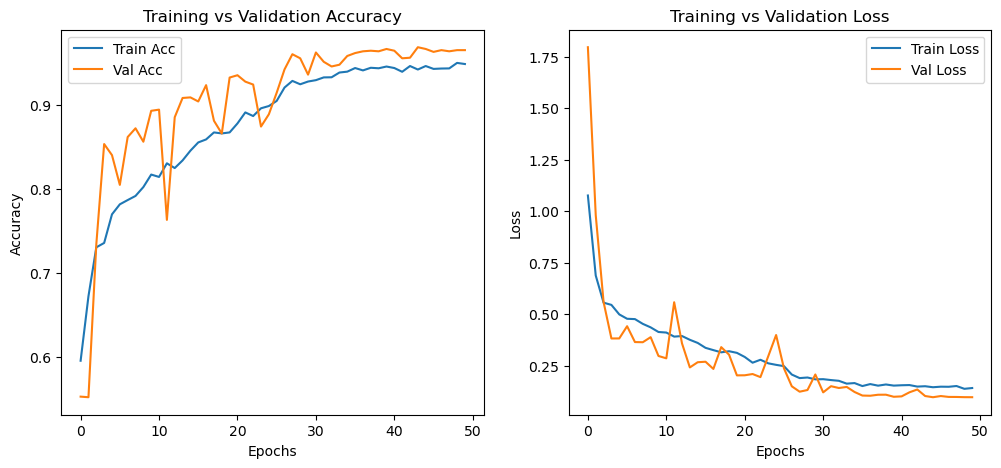

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 375ms/step


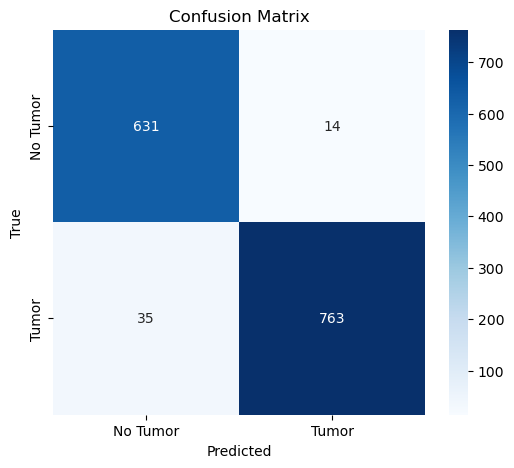

Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.95      0.98      0.96       645
       Tumor       0.98      0.96      0.97       798

    accuracy                           0.97      1443
   macro avg       0.96      0.97      0.97      1443
weighted avg       0.97      0.97      0.97      1443



In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


# Predict on validation set
y_pred = cnn_model.predict(validation_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=["No Tumor", "Tumor"]))

In [48]:
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True
)

val_generator = datagen_valid.flow_from_dataframe(
    dataframe=val_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False
)


Found 6732 validated image filenames belonging to 2 classes.
Found 1443 validated image filenames belonging to 2 classes.
Found 1443 validated image filenames belonging to 2 classes.


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [50]:
base_model = DenseNet201(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model initially
base_model.trainable = False


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 47s 1us/step 


In [51]:
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 230, 230, 3)       │               0 │ input_layer_16[0][0]       │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 18,814,017 (71.77 MB)

 Trainable params: 492,033 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7),
    ModelCheckpoint("DenseNet model.keras", monitor="val_accuracy", save_best_only=True)
]


In [53]:
history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=callbacks)

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6450 - loss: 0.6634   

211/211 ━━━━━━━━━━━━━━━━━━━━ 887s 4s/step - accuracy: 0.7063 - loss: 0.5692 - val_accuracy: 0.8836 - val_loss: 0.3162 - learning_rate: 1.0000e-04
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7872 - loss: 0.4550  

211/211 ━━━━━━━━━━━━━━━━━━━━ 815s 4s/step - accuracy: 0.7993 - loss: 0.4405 - val_accuracy: 0.8974 - val_loss: 0.2556 - learning_rate: 1.0000e-04
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8260 - loss: 0.3856   

211/211 ━━━━━━━━━━━━━━━━━━━━ 857s 4s/step - accuracy: 0.8353 - loss: 0.3786 - val_accuracy: 0.9071 - val_loss: 0.2348 - learning_rate: 1.0000e-04
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8393 - loss: 0.3705   

211/211 ━━━━━━━━━━━━━━━━━━━━ 814s 4s/step - accuracy: 0.8440 - loss: 0.3619 - val_accuracy: 0.9245 - val_loss: 0.2129 - learning_rate: 1.0000e-04
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 839s 4s/step - accuracy: 0.8477 - loss: 0.3517 - val_accuracy: 0.9182 - val_loss: 0.2116 - learning_rate: 1.0000e-04
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 850s 4s/step - accuracy: 0.8549 - loss: 0.3393 - val_accuracy: 0.9182 - val_loss: 0.2048 - learning_rate: 1.0000e-04
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8536 - loss: 0.3412  

211/211 ━━━━━━━━━━━━━━━━━━━━ 763s 4s/step - accuracy: 0.8535 - loss: 0.3410 - val_accuracy: 0.9272 - val_loss: 0.1934 - learning_rate: 1.0000e-04
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8572 - loss: 0.3277  

211/211 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - accuracy: 0.8605 - loss: 0.3259 - val_accuracy: 0.9279 - val_loss: 0.1891 - learning_rate: 1.0000e-04
Epoch 9/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8678 - loss: 0.3152  

211/211 ━━━━━━━━━━━━━━━━━━━━ 760s 4s/step - accuracy: 0.8693 - loss: 0.3116 - val_accuracy: 0.9307 - val_loss: 0.1816 - learning_rate: 1.0000e-04
Epoch 10/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8693 - loss: 0.3127   

211/211 ━━━━━━━━━━━━━━━━━━━━ 778s 4s/step - accuracy: 0.8684 - loss: 0.3109 - val_accuracy: 0.9383 - val_loss: 0.1787 - learning_rate: 1.0000e-04


In [54]:
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

In [55]:
model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = model.fit(train_generator, validation_data=val_generator, epochs=20, callbacks=callbacks)

Epoch 1/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 934s 4s/step - accuracy: 0.8682 - loss: 0.3195 - val_accuracy: 0.9265 - val_loss: 0.1688 - learning_rate: 1.0000e-05
Epoch 2/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 879s 4s/step - accuracy: 0.8865 - loss: 0.2812 - val_accuracy: 0.9369 - val_loss: 0.1509 - learning_rate: 1.0000e-05
Epoch 3/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.8990 - loss: 0.2480 - val_accuracy: 0.9383 - val_loss: 0.1413 - learning_rate: 1.0000e-05
Epoch 4/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8940 - loss: 0.2533   

211/211 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.8951 - loss: 0.2508 - val_accuracy: 0.9439 - val_loss: 0.1299 - learning_rate: 1.0000e-05
Epoch 5/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9023 - loss: 0.2510   

211/211 ━━━━━━━━━━━━━━━━━━━━ 875s 4s/step - accuracy: 0.9106 - loss: 0.2291 - val_accuracy: 0.9494 - val_loss: 0.1216 - learning_rate: 1.0000e-05
Epoch 6/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 875s 4s/step - accuracy: 0.9173 - loss: 0.2100 - val_accuracy: 0.9487 - val_loss: 0.1156 - learning_rate: 1.0000e-05
Epoch 7/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9246 - loss: 0.2000   

211/211 ━━━━━━━━━━━━━━━━━━━━ 876s 4s/step - accuracy: 0.9187 - loss: 0.2082 - val_accuracy: 0.9536 - val_loss: 0.1088 - learning_rate: 1.0000e-05
Epoch 8/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9207 - loss: 0.1971   

211/211 ━━━━━━━━━━━━━━━━━━━━ 874s 4s/step - accuracy: 0.9248 - loss: 0.1904 - val_accuracy: 0.9577 - val_loss: 0.1031 - learning_rate: 1.0000e-05
Epoch 9/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 878s 4s/step - accuracy: 0.9327 - loss: 0.1758 - val_accuracy: 0.9543 - val_loss: 0.0993 - learning_rate: 1.0000e-05
Epoch 10/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9322 - loss: 0.1835   

211/211 ━━━━━━━━━━━━━━━━━━━━ 880s 4s/step - accuracy: 0.9321 - loss: 0.1765 - val_accuracy: 0.9605 - val_loss: 0.0952 - learning_rate: 1.0000e-05
Epoch 11/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 876s 4s/step - accuracy: 0.9373 - loss: 0.1665 - val_accuracy: 0.9605 - val_loss: 0.0900 - learning_rate: 1.0000e-05
Epoch 12/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9348 - loss: 0.1690   

211/211 ━━━━━━━━━━━━━━━━━━━━ 894s 4s/step - accuracy: 0.9367 - loss: 0.1667 - val_accuracy: 0.9626 - val_loss: 0.0874 - learning_rate: 1.0000e-05
Epoch 13/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9330 - loss: 0.1760   

211/211 ━━━━━━━━━━━━━━━━━━━━ 897s 4s/step - accuracy: 0.9358 - loss: 0.1686 - val_accuracy: 0.9695 - val_loss: 0.0826 - learning_rate: 1.0000e-05
Epoch 14/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 894s 4s/step - accuracy: 0.9413 - loss: 0.1516 - val_accuracy: 0.9681 - val_loss: 0.0789 - learning_rate: 1.0000e-05
Epoch 15/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 9825s 47s/step - accuracy: 0.9453 - loss: 0.1505 - val_accuracy: 0.9660 - val_loss: 0.0768 - learning_rate: 1.0000e-05
Epoch 16/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 1024s 5s/step - accuracy: 0.9424 - loss: 0.1467 - val_accuracy: 0.9667 - val_loss: 0.0747 - learning_rate: 1.0000e-05
Epoch 17/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 969s 5s/step - accuracy: 0.9446 - loss: 0.1412 - val_accuracy: 0.9667 - val_loss: 0.0728 - learning_rate: 1.0000e-05
Epoch 18/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 931s 4s/step - accuracy: 0.9495 - loss: 0.1353 - val_accuracy: 0.9674 - val_loss: 0.0720 - learning_rate: 1.0000e-05
Epoch 19/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accurac

211/211 ━━━━━━━━━━━━━━━━━━━━ 903s 4s/step - accuracy: 0.9482 - loss: 0.1310 - val_accuracy: 0.9730 - val_loss: 0.0686 - learning_rate: 1.0000e-05
Epoch 20/20
211/211 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9516 - loss: 0.1271   

211/211 ━━━━━━━━━━━━━━━━━━━━ 1050s 5s/step - accuracy: 0.9496 - loss: 0.1322 - val_accuracy: 0.9751 - val_loss: 0.0648 - learning_rate: 1.0000e-05


In [56]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.9681 - loss: 0.0890
✅ Test Accuracy: 0.9681


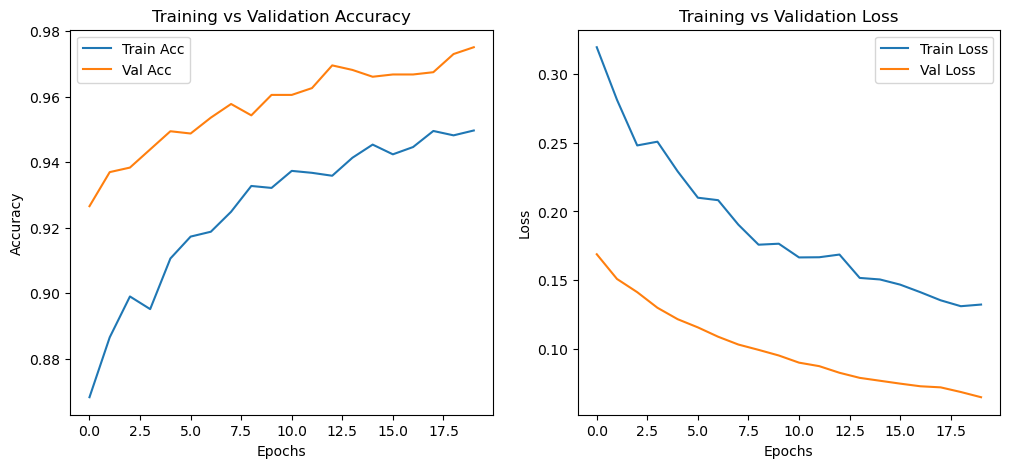

46/46 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step


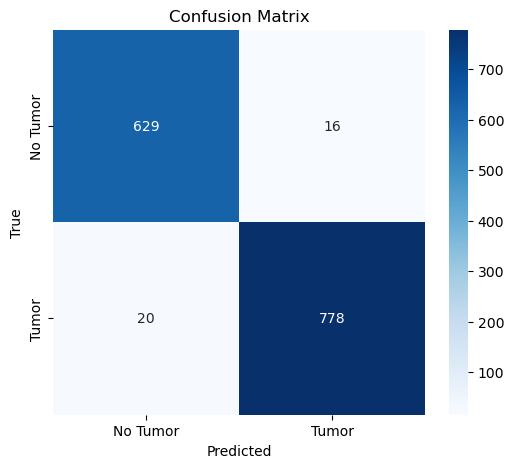

Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.97      0.98      0.97       645
       Tumor       0.98      0.97      0.98       798

    accuracy                           0.98      1443
   macro avg       0.97      0.98      0.97      1443
weighted avg       0.98      0.98      0.98      1443



In [58]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


# Predict on validation set
y_pred = model.predict(validation_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=["No Tumor", "Tumor"]))